In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error
import xgboost as xgb


## Preparing Features

In [4]:
df_features = pd.read_csv('/content/final_provider_features.csv')
df_features_pre = df_features.copy()
df_features_pre ['potentialfraud'] = df_features_pre ['potentialfraud'].map({'Yes': 1, 'No': 0})
X = df_features_pre.drop(['provider','potentialfraud'], axis=1)
Y = df_features_pre['potentialfraud']

correlation_matrix = X.corr().abs()
uppertri_corr = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in uppertri_corr.columns if any(uppertri_corr[column] > 0.9)]
print("Highly correlated feature pairs (correlation > 0.9):")

for i in range(len(uppertri_corr.columns)):
    for j in range(i + 1, len(uppertri_corr.columns)):
        if uppertri_corr.iloc[i, j] > 0.9:
            print(f"  - {uppertri_corr.columns[i]} and {uppertri_corr.columns[j]}: {uppertri_corr.iloc[i, j]:.4f}")

if not highly_correlated_features:
    print("No feature pairs found with correlation > 0.9.")




Highly correlated feature pairs (correlation > 0.9):
  - claimid_count and beneid_nunique: 0.9389
  - claimid_count and numdiagnoses_sum: 0.9067
  - claimid_count and gender_<lambda>: 0.9682
  - claimid_count and chroniccond_alzheimer_sum: 0.9714
  - claimid_count and chroniccond_heartfailure_sum: 0.9860
  - claimid_count and chroniccond_kidneydisease_sum: 0.9715
  - claimid_count and chroniccond_cancer_sum: 0.9107
  - claimid_count and chroniccond_diabetes_sum: 0.9897
  - claimid_count and chroniccond_ischemicheart_sum: 0.9910
  - claimid_count and chroniccond_osteoporasis_sum: 0.9549
  - claimid_count and chroniccond_rheumatoidarthritis_sum: 0.9548
  - claimid_count and renaldiseaseindicator_sum: 0.9217
  - claimid_count and total_chronic_conditions: 0.9927
  - beneid_nunique and numdiagnoses_sum: 0.9667
  - beneid_nunique and chroniccond_alzheimer_sum: 0.9030
  - beneid_nunique and chroniccond_heartfailure_sum: 0.9112
  - beneid_nunique and chroniccond_kidneydisease_sum: 0.9262
  - 

In [5]:
features_to_drop = [
    'beneid_nunique',
    'numdiagnoses_sum',
    'gender_<lambda>',
    'chroniccond_alzheimer_sum',
    'chroniccond_heartfailure_sum',
    'chroniccond_kidneydisease_sum',
    'chroniccond_cancer_sum',
    'chroniccond_diabetes_sum',
    'chroniccond_ischemicheart_sum',
    'chroniccond_osteoporasis_sum',
    'chroniccond_rheumatoidarthritis_sum',
    'renaldiseaseindicator_sum',
    'deductibleamtpaid_sum',
    'claim_type_<lambda>',
    'avg_reimbursement_per_patient',
    'inpatient_ratio',
    'outpatient_ratio',
    'sameday_claim_ratio',
    'isweekendclaim_sum',
    'hasmultiplediagnoses_sum',
    'highreimbursement_sum'
]

X_filtered = X.drop(columns=features_to_drop)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features after dropping highly correlated ones: {X_filtered.shape[1]}")

X = X_filtered.copy()

Original number of features: 55
Number of features after dropping highly correlated ones: 34


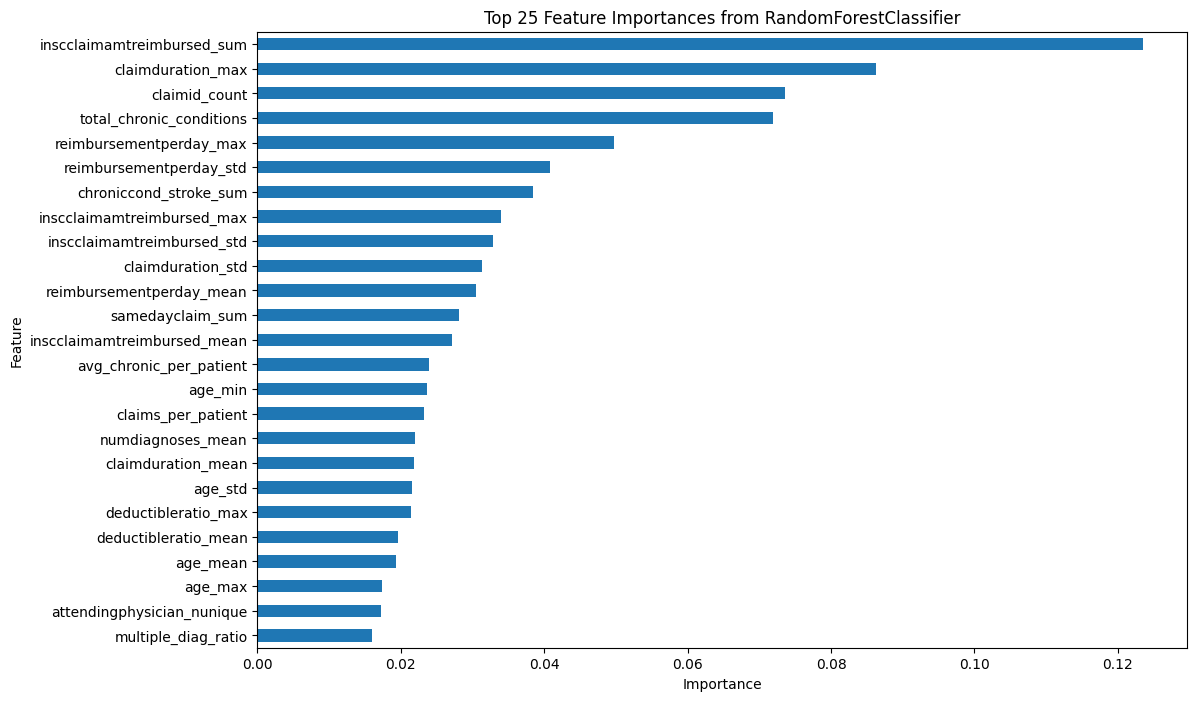

In [10]:
model = RandomForestClassifier(n_estimators=100 , random_state=42)
model.fit(X , Y)

feature_importances = pd.Series(model.feature_importances_ , index=X.columns)
sorted_importances = feature_importances.sort_values(ascending=False)
top25_features = sorted_importances.head(25).index.tolist()
X_selected = X[top25_features]
X = X_selected.copy()

plt.figure(figsize=(12, 8))
sorted_importances.head(25).plot(kind='barh')
plt.title('Top 25 Feature Importances from RandomForestClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()



## **Models Training**

## Logistic Regression Model

In [16]:
df_test = pd.read_csv('/content/Test-1542969243754.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

log_model = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear') # Added solver for robustness
log_model.fit(X_train_scaled, Y_train)

y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Report")
print(classification_report(Y_test, y_pred))
print("ROC AUC:", roc_auc_score(Y_test, y_prob))

Shape of X_train: (3372, 25)
Shape of X_test: (843, 25)
Shape of Y_train: (3372,)
Shape of Y_test: (843,)
Logistic Regression Report
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       742
           1       0.45      0.86      0.59       101

    accuracy                           0.86       843
   macro avg       0.71      0.86      0.75       843
weighted avg       0.92      0.86      0.88       843

ROC AUC: 0.920498518854581


## Decision Trees Model

In [18]:
df_test = pd.read_csv('/content/Test-1542969243754.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print("Decision Tree Report")
print(classification_report(Y_test, y_pred))
print("ROC AUC:", roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))

Decision Tree Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       742
           1       0.57      0.65      0.61       101

    accuracy                           0.90       843
   macro avg       0.76      0.79      0.78       843
weighted avg       0.91      0.90      0.90       843

ROC AUC: 0.7937138053427985


## Gradiant Boosting Model

In [20]:
df_test = pd.read_csv('/content/Test-1542969243754.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_imputed, Y_train)
y_pred = model.predict(X_test_imputed)

print("Gradient Boosting Report")
print(classification_report(Y_test, y_pred))
print("ROC AUC:", roc_auc_score(Y_test, model.predict_proba(X_test_imputed)[:,1]))

Gradient Boosting Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       742
           1       0.72      0.62      0.67       101

    accuracy                           0.93       843
   macro avg       0.83      0.80      0.81       843
weighted avg       0.92      0.93      0.92       843

ROC AUC: 0.9293053294547784
